<a href="https://colab.research.google.com/github/bhuvanabasapur/CMPE-258/blob/master/Assignments/Assignment%205/Assignment5_part_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [4]:
!pip install -q kaggle
from google.colab import files


In [5]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

GCP-Coupons-Instructions.rtf: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#unzip train.csv.zip
import zipfile
zf = '/content/train.csv.zip'
zip_ref = zipfile.ZipFile(zf, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
df = pd.read_csv('/content/train.csv', parse_dates=True, infer_datetime_format=True)
#since the colab keeps crashing while trying to read train.csv importing from drive
# path = '/content/drive/MyDrive/Colab Notebooks/CMPE 258/Assignments/train.csv'
# df = pd.read_csv(path)[:15000]


In [18]:
import requests
from io import BytesIO

r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ72HRGTlPQLtJLJpZxV1_UdpnfmkZoGpDS-J5Rm9ecppPpSOcdUN1u5Z-FMk6_LVzbRXUGhQnb0vJd/pub?gid=1290799616&single=true&output=tsv')
data = r.content
df = pd.read_csv(BytesIO(data), sep='\t', index_col=0)



In [19]:
df.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
6918581,2012-04-20 18:20:00,9.7,2012-04-20 18:20:00 UTC,-73.957867,40.765155,-73.984122,40.759095,4
6135694,2009-12-19 15:43:21,4.1,2009-12-19 15:43:21 UTC,-73.954563,40.780773,-73.961841,40.779553,1
38328861,2014-08-17 8:24:36,6.0,2014-08-17 08:24:36 UTC,-73.992020,40.748710,-74.001072,40.755467,2
28356410,2011-01-01 13:48:15,7.3,2011-01-01 13:48:15 UTC,-73.973956,40.743322,-73.990257,40.756541,1
8634320,2009-12-15 22:33:21,6.9,2009-12-15 22:33:21 UTC,-73.979009,40.761543,-73.996857,40.742475,1


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6918581 to 8424025
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                25000 non-null  object 
 1   fare_amount        25000 non-null  float64
 2   pickup_datetime    25000 non-null  object 
 3   pickup_longitude   25000 non-null  float64
 4   pickup_latitude    25000 non-null  float64
 5   dropoff_longitude  25000 non-null  float64
 6   dropoff_latitude   25000 non-null  float64
 7   passenger_count    25000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 1.7+ MB


Data Preprocessing

In [9]:
df.isnull().sum()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [21]:
df = df.dropna()

In [22]:
df.nunique()

key                  24947
fare_amount            533
pickup_datetime      24947
pickup_longitude     19965
pickup_latitude      20901
dropoff_longitude    20291
dropoff_latitude     21270
passenger_count          7
dtype: int64

In [23]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,11.230264,-72.498820,39.953620,-72.456549,39.911780,1.676000
std,9.481905,10.443341,7.071689,10.585145,6.566459,1.304198
min,0.000000,-74.689831,-74.000353,-74.689831,-74.001537,0.000000
25%,6.000000,-73.991920,40.735795,-73.991259,40.734021,1.000000
50%,8.500000,-73.981830,40.752976,-73.980136,40.753131,1.000000
75%,12.500000,-73.967197,40.767344,-73.963265,40.768369,2.000000
max,300.000000,40.769807,482.500000,40.774482,404.216667,6.000000


In [24]:
def extract_time_features(df):
  df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
  df['trip_start_month']= df['pickup_datetime'].dt.month
  df['trip_start_day'] = df['pickup_datetime'].dt.dayofweek
  df['trip_start_hour'] = df['pickup_datetime'].dt.hour
  return df

In [25]:
df = extract_time_features(df)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 6918581 to 8424025
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                25000 non-null  object             
 1   fare_amount        25000 non-null  float64            
 2   pickup_datetime    25000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   25000 non-null  float64            
 4   pickup_latitude    25000 non-null  float64            
 5   dropoff_longitude  25000 non-null  float64            
 6   dropoff_latitude   25000 non-null  float64            
 7   passenger_count    25000 non-null  int64              
 8   trip_start_month   25000 non-null  int64              
 9   trip_start_day     25000 non-null  int64              
 10  trip_start_hour    25000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(4), object(1)
memory usage: 2.3+ MB


In [28]:
df=df.drop(['key','pickup_datetime'], axis=1)

Exploratory Data Analysis

In [22]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_day,trip_start_hour
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000
mean,11.283037,-72.458556,39.912188,-72.453151,39.888690,1.640461,6.243649,3.031073,13.510302
std,9.628779,10.600645,6.902721,10.613594,6.240467,1.264430,3.445434,1.967181,6.511914
min,0.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000,1.000000,0.000000,0.000000
25%,6.000000,-73.992167,40.734740,-73.991182,40.734659,1.000000,3.000000,1.000000,9.000000
50%,8.500000,-73.981696,40.752632,-73.980133,40.753660,1.000000,6.000000,3.000000,14.000000
75%,12.500000,-73.966766,40.767452,-73.963610,40.768100,2.000000,9.000000,5.000000,19.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000,12.000000,6.000000,23.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


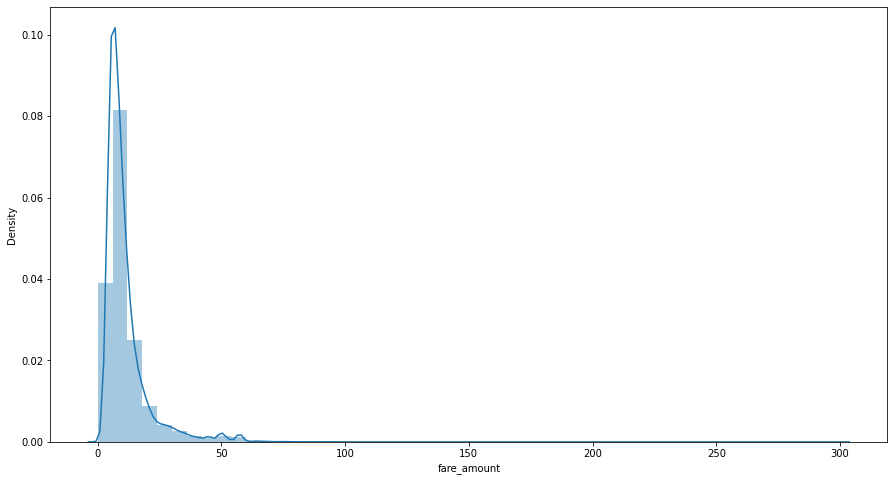

In [27]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(df['fare_amount'])

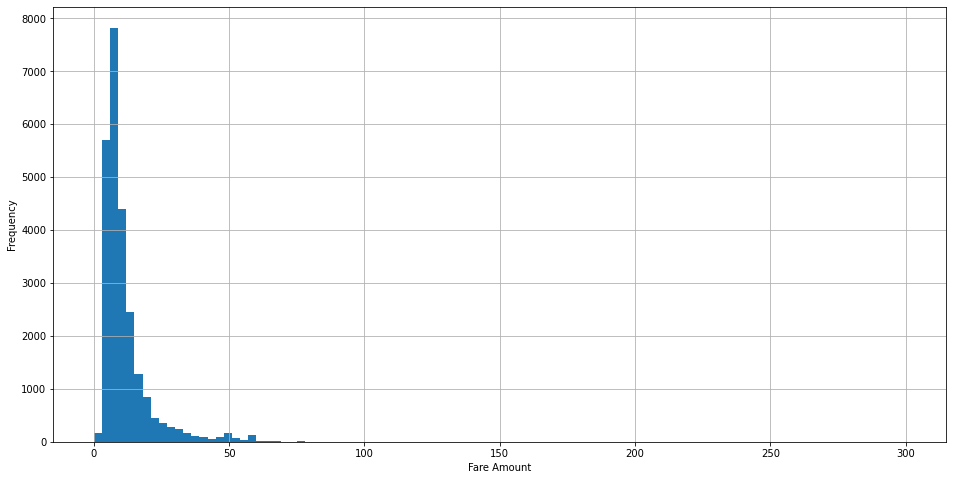

In [29]:
df.fare_amount.hist(bins=100, figsize = (16, 8))
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.show()

In [ ]:
m = folium.Map()
sw = df[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = df[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(df['pickup_latitude'], df['pickup_longitude'], df['fare_amount']), radius = 10))
m.fit_bounds([sw, ne])
m

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

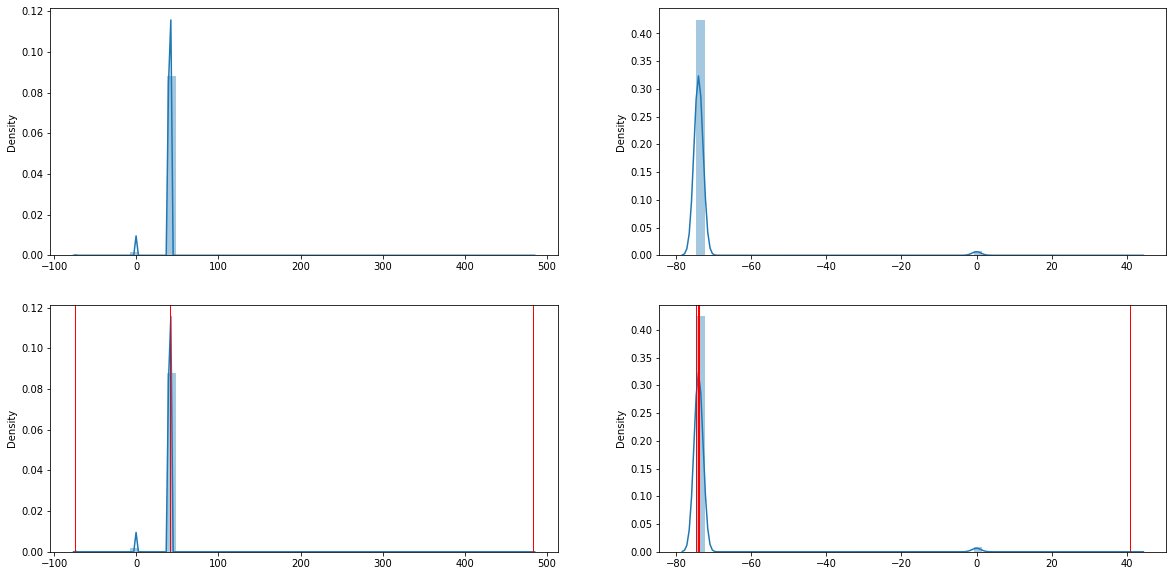

In [31]:
##Quantile Bucketization of latitude and longitude
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

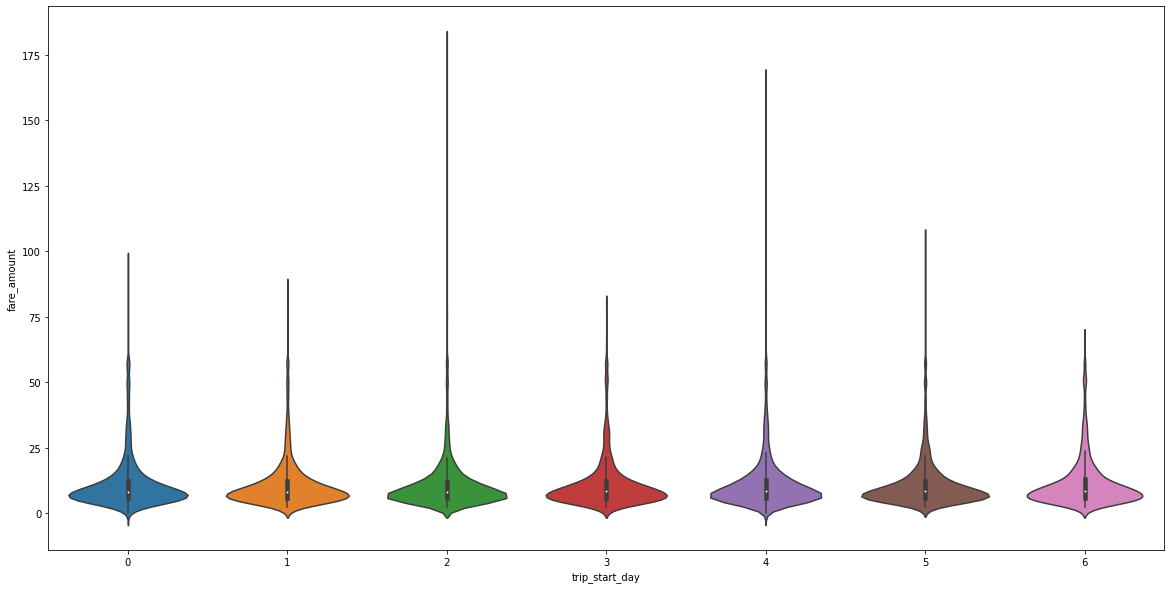

In [25]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=df['trip_start_day'], y=df['fare_amount'])

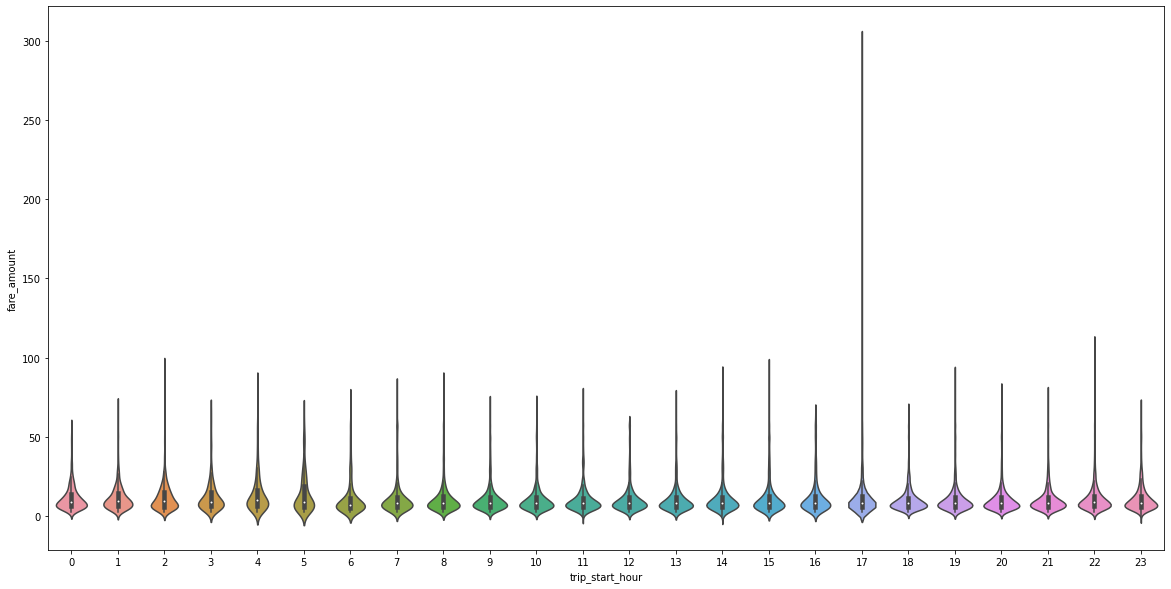

In [32]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=df['trip_start_hour'], y=df['fare_amount'])

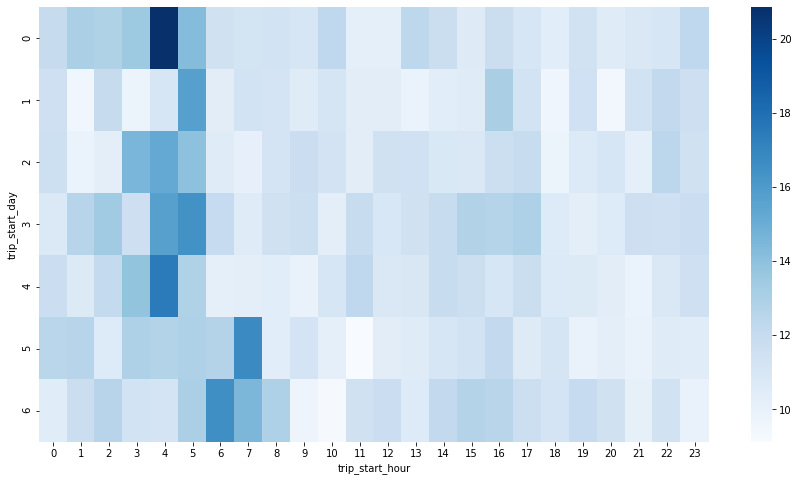

In [33]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(df['trip_start_day'] , df['trip_start_hour'] , df['fare_amount'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='Blues')

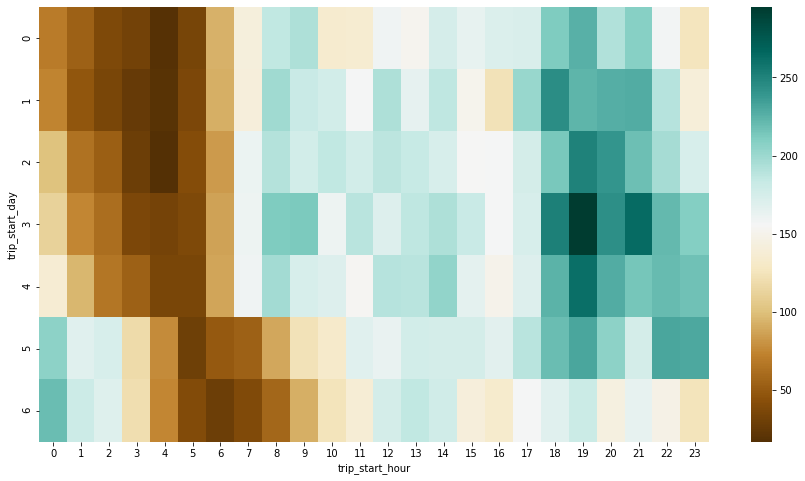

In [34]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(df['trip_start_day'] , df['trip_start_hour'] , df.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='BrBG')

# Feature Engineering

Create new feature distance - calculated by Euclidian distance

In [35]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

df = df.apply(euclidean, axis=1)
df.head()  

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_day,trip_start_hour,distance
6918581,9.7,-73.957867,40.765155,-73.984122,40.759095,4.0,4.0,4.0,18.0,2.694529
6135694,4.1,-73.954563,40.780773,-73.961841,40.779553,1.0,12.0,5.0,15.0,0.737954
38328861,6.0,-73.992020,40.748710,-74.001072,40.755467,2.0,8.0,6.0,8.0,1.129583
28356410,7.3,-73.973956,40.743322,-73.990257,40.756541,1.0,1.0,5.0,13.0,2.098725
8634320,6.9,-73.979009,40.761543,-73.996857,40.742475,1.0,12.0,1.0,22.0,2.611780


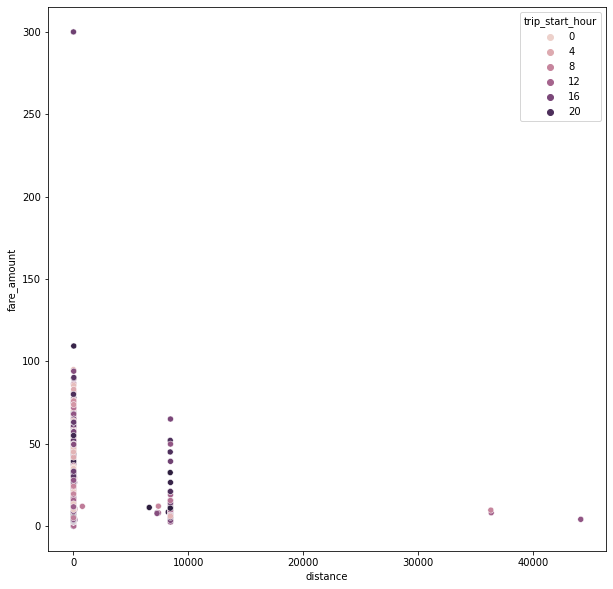

In [36]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=df['distance'], y=df['fare_amount'], hue=df['trip_start_hour'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



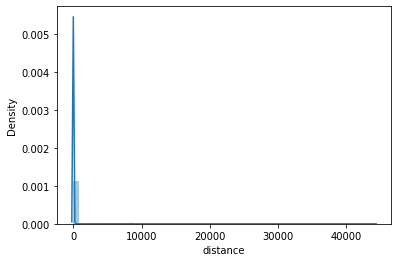

In [38]:
sns.distplot(df['distance'], kde=True)

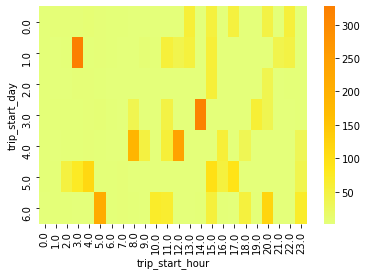

In [39]:
##Average trip distance( day-hour wise )

cross = pd.crosstab(df['trip_start_day'] , df['trip_start_hour'] , df['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='Wistia')

Data Ingestion Pieline (ETL)

In [53]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train1.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

21257
3743


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_start_month,trip_start_day,trip_start_hour,distance
6918581,9.7,-73.957867,40.765155,-73.984122,40.759095,4.0,4.0,4.0,18.0,2.694529
6135694,4.1,-73.954563,40.780773,-73.961841,40.779553,1.0,12.0,5.0,15.0,0.737954
38328861,6.0,-73.992020,40.748710,-74.001072,40.755467,2.0,8.0,6.0,8.0,1.129583
28356410,7.3,-73.973956,40.743322,-73.990257,40.756541,1.0,1.0,5.0,13.0,2.098725
8634320,6.9,-73.979009,40.761543,-73.996857,40.742475,1.0,12.0,1.0,22.0,2.611780


In [54]:
#Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5
  # features['pickup_datetime'] = pd.to_datetime(features['pickup_datetime'])
  # features['trip_start_month']= features['pickup_datetime'].dt.month
  # features['trip_start_day'] = features['pickup_datetime'].dt.dayofweek
  # features['trip_start_hour'] = features['pickup_datetime'].dt.hour
  #features = features.drop('key', axis=1)
  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [57]:

###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare_amount'
print(f'csv columns: {CSV_COLUMNS}')

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], [0.0],[0.0],[0.0],[0.0], [1.0] ,['1'], ['1'],['1'],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        if v_test == True:
          print(next(dataset.__iter__()))

        return dataset
    return _input_fn

csv columns: Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'trip_start_month', 'trip_start_day', 'trip_start_hour', 'distance'],
      dtype='object')


In [58]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.95652 , -73.78237 , -73.97459 , -73.87268 , -73.98319 ,
       -73.99203 , -73.998695, -73.97387 , -73.96155 , -73.985374],
      dtype=float32)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.77128 , 40.6446  , 40.750317, 40.774513, 40.75285 , 40.754036,
       40.739956, 40.7593  , 40.75992 , 40.764294], dtype=float32)>), ('dropoff_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.982254, -73.963165, -73.98805 , -74.00464 , -74.00214 ,
       -73.97663 , -73.96616 , -73.97159 , -73.95228 , -73.942474],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([40.736073, 40.774174, 40.759823, 40.717304, 40.734886, 40.764725,
       40.76549 , 40.760284, 40.76629 , 40.75394 ], dtype=float32)>), ('passenger_count', <tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 5., 1., 1., 1., 1., 1., 1., 1., 1

<DatasetV1Adapter shapes: (OrderedDict([(pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (passenger_count, (None,)), (trip_start_month, (None,)), (trip_start_day, (None,)), (trip_start_hour, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (passenger_count, tf.float32), (trip_start_month, tf.string), (trip_start_day, tf.string), (trip_start_hour, tf.string), (distance, tf.float32)]), tf.float32)>

In [59]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21257 entries, 6918581 to 8424025
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        21257 non-null  float64
 1   pickup_longitude   21257 non-null  float64
 2   pickup_latitude    21257 non-null  float64
 3   dropoff_longitude  21257 non-null  float64
 4   dropoff_latitude   21257 non-null  float64
 5   passenger_count    21257 non-null  float64
 6   trip_start_month   21257 non-null  float64
 7   trip_start_day     21257 non-null  float64
 8   trip_start_hour    21257 non-null  float64
 9   distance           21257 non-null  float64
dtypes: float64(10)
memory usage: 1.8 MB


In [60]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_passengercnt = tf.keras.Input(name='passenger_count', shape=(1,), dtype=tf.int64)
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'pickup_longitude': k_picklon,'pickup_latitude': k_picklat,
                        'dropoff_longitude': k_droplon,'dropoff_latitude': k_droplat,
                        'passenger_count': k_passengercnt, 'trip_start_month': k_month,
                         'trip_start_day' : k_day,'trip_start_hour': k_hour,        
                          'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'passenger_count': <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'passenger_count')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

# Model - Training Pipeline

Build DNN with following feature Engineering Techniques:
- One-hot Encoding of categorical features
- Feature cross: Cross-join categorical attributes( ex: Lat cross Lon )
- Network architecture: Wide( Categorical ) and Deep( Continuous features )
- Regularization( Overfit prevention ): L2
- Uses GPU / TPU as distribution infra

In [64]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 3
}

In [68]:
def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [66]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   
                  steps_per_epoch = 100,   
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

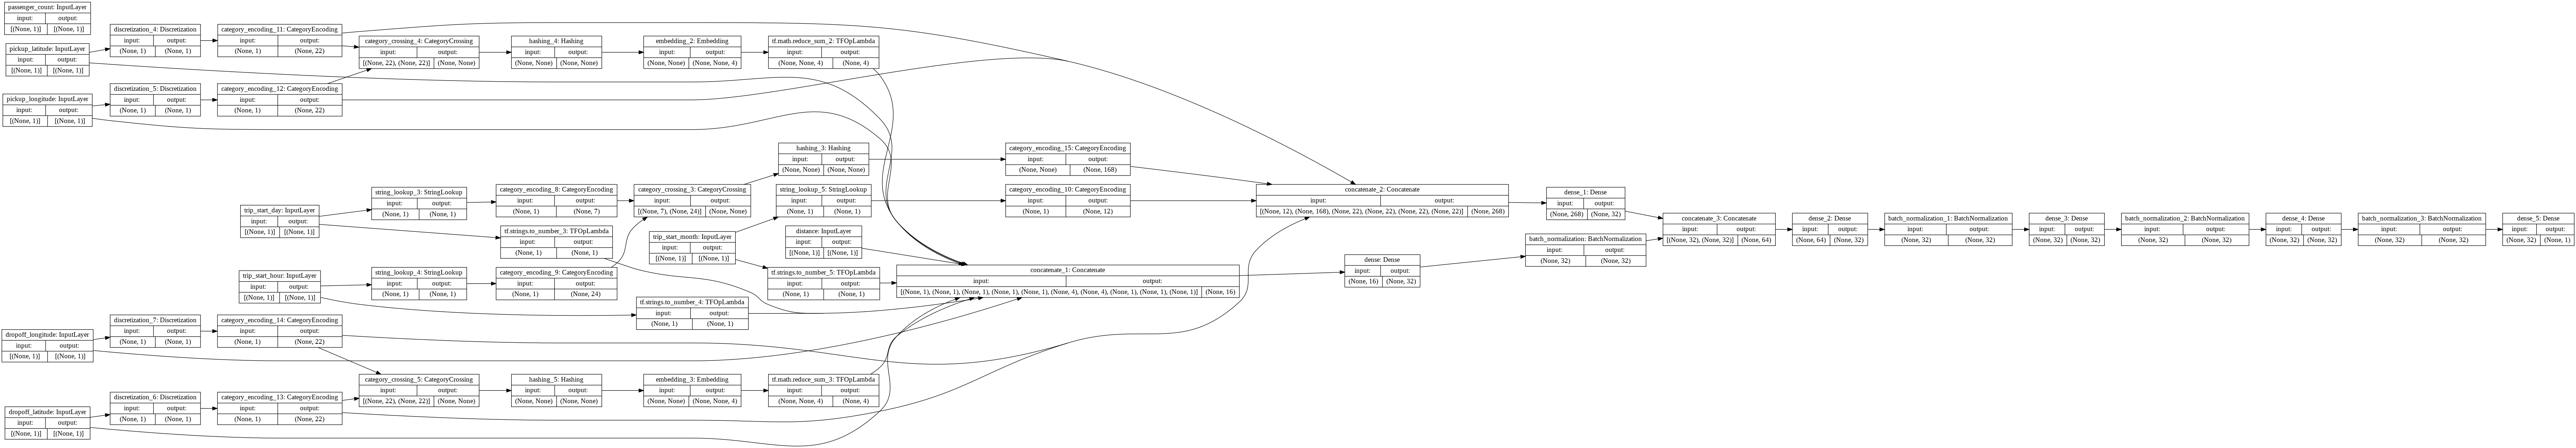

In [69]:
#Create dataset input functions
train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 128)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 512)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [70]:
keras_train_and_evaluate(m_, train_dataset, validation_dataset, 50)

Epoch 1/50
100/100 [==============================] - 23s 186ms/step - loss: 187.8869 - rmse: 13.6911 - val_loss: 108.7124 - val_rmse: 10.4262
Epoch 2/50
100/100 [==============================] - 18s 177ms/step - loss: 159.6975 - rmse: 12.5604 - val_loss: 90.2962 - val_rmse: 9.5022
Epoch 3/50
100/100 [==============================] - 18s 177ms/step - loss: 80.8288 - rmse: 8.9882 - val_loss: 98.4530 - val_rmse: 9.9222
Epoch 4/50
100/100 [==============================] - 18s 175ms/step - loss: 70.8868 - rmse: 8.4110 - val_loss: 133.1979 - val_rmse: 11.5410
Epoch 5/50
100/100 [==============================] - 18s 177ms/step - loss: 58.6167 - rmse: 7.6489 - val_loss: 76.6443 - val_rmse: 8.7545
Epoch 6/50
100/100 [==============================] - 17s 173ms/step - loss: 44.2006 - rmse: 6.6404 - val_loss: 59.4302 - val_rmse: 7.7089
Epoch 7/50
100/100 [==============================] - 17s 173ms/step - loss: 47.9914 - rmse: 6.9097 - val_loss: 44.7419 - val_rmse: 6.6887
Epoch 8/50
100/100 